In [71]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

In [72]:
def inspect_vessel(MMSI, tracks, Plot=False):
    vessel = pd.DataFrame.from_dict(tracks[MMSI])
    vessel.DTG = pd.to_datetime(vessel['DTG'])
    vessel.lat = pd.to_numeric(vessel['lat'])
    vessel.lon = pd.to_numeric(vessel['lon'])
    vessel.COG = pd.to_numeric(vessel['COG'])
    vessel.SOG = pd.to_numeric(vessel['SOG'])
    vessel.sort_values('DTG', ignore_index=True, inplace=True)
    vessel['geometry'] = [Point(xy) for xy in zip(vessel.lon, vessel.lat)]
    
    if Plot:
        vessel.plot(x='lon', y='lat')
        vessel.plot(y='SOG')
    
    return vessel.dropna()

In [83]:
def detect_mooring(df):
    min_speed = (df.SOG.rolling(10).mean() < 2).to_numpy()
    
    transitions = np.where(min_speed[:-1] != (min_speed[1:]))[0]
    transitions = np.insert(transitions, 0, 0)
    transitions = np.append(transitions, df.shape[0])
    #print(transitions)
    
    mean_SOG = []
    mean_lat = []
    mean_lon = []

    for i in range(len(transitions) - 1):
        mean_SOG.append(df.SOG[transitions[i]:transitions[i+1]].mean())
        mean_lat.append(df.lat[transitions[i]:transitions[i+1]].mean())
        mean_lon.append(df.lon[transitions[i]:transitions[i+1]].mean())

    mean_SOG = np.array(mean_SOG)
    moored   = np.where(mean_SOG < 1)[0]
    print(moored)
    mean_lat = list(np.array(mean_lat)[moored])
    mean_lon = list(np.array(mean_lon)[moored])
    
    return(mean_lat, mean_lon)

In [80]:
def detect_transit(df):
    min_speed = (df.SOG.rolling(10).mean() < 2).to_numpy()
    
    transitions = np.where(min_speed[:-1] != (min_speed[1:]))[0]
    transitions = np.insert(transitions, 0, 0)
    transitions = np.append(transitions, df.shape[0])
    print(transitions)
    
    mean_SOG = []
    mean_lat = []
    mean_lon = []

    for i in range(len(transitions) - 1):
        mean_SOG.append(df.SOG[transitions[i]:transitions[i+1]].mean())
        mean_lat.append(df.lat[transitions[i]:transitions[i+1]].mean())
        mean_lon.append(df.lon[transitions[i]:transitions[i+1]].mean())

    mean_SOG = np.array(mean_SOG)
    moored   = np.where(mean_SOG > 1)[0]
    print(moored)
    #mean_lat = list(np.array(mean_lat)[moored])
    #mean_lon = list(np.array(mean_lon)[moored])
    
    #return(mean_lat, mean_lon)

In [4]:
MMSIs = set()

In [5]:
with open('../../ais/data/AIS_2015_01_SF_Bay.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # Skip the header
    foo = next(reader)
    for row in reader:
        MMSIs.add(row[0])

In [6]:
len(MMSIs)

711

In [7]:
tracks = {MMSI: {'lat': [], 'lon': [], 'DTG': [], 'COG': [], 'SOG': []} for MMSI in MMSIs}

In [8]:
with open('../../ais/data/AIS_2015_01_SF_Bay.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # Skip the header
    for row in reader:
        tracks[row[0]]['lat'].append(row[2])
        tracks[row[0]]['lon'].append(row[3])
        tracks[row[0]]['DTG'].append(row[1])
        tracks[row[0]]['COG'].append(row[5])
        tracks[row[0]]['SOG'].append(row[4])

In [66]:
moor_lat = {}
moor_lon = {}

for MMSI in MMSIs:
    vsl = inspect_vessel(MMSI, tracks)
    lat, lon = detect_mooring(vsl)
    moor_lat[MMSI] = lat
    moor_lon[MMSI] = lon

In [67]:
moor_lat = list(moor_lat.values())
moor_lon = list(moor_lon.values())

In [68]:
lat = np.array([lat for vessel in moor_lat for lat in vessel])
lon = np.array([lon for vessel in moor_lon for lon in vessel])

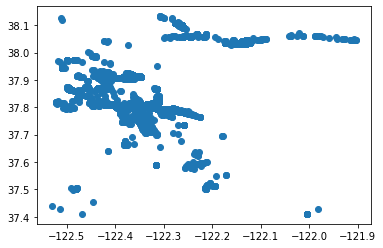

In [70]:
plt.scatter(lon, lat)

In [77]:
foo = inspect_vessel('367568420', tracks)

In [84]:
detect_mooring(foo)

[ 0  9 13 15]


([37.806205, 37.85709000000001, 37.841215, 37.91411333333334],
 [-122.44555, -122.47676000000006, -122.457605, -122.35261333333334])

,lat,lon,DTG,COG,SOG,geometry
0,37.80604,-122.44574,2015-01-01 06:40:56,-49.6,0.0,POINT (-122.44574 37.80604)
1,37.80607,-122.44573,2015-01-01 06:41:57,-49.6,0.0,POINT (-122.44573 37.80607)
2,37.80604,-122.44574,2015-01-01 06:43:32,-49.6,0.0,POINT (-122.44574 37.80604)
3,37.80605,-122.44571,2015-01-01 06:45:30,-49.6,0.0,POINT (-122.44571 37.80605)
4,37.80606,-122.44573,2015-01-01 06:49:29,-49.6,0.0,POINT (-122.44573 37.80606)
...,...,...,...,...,...,...
558,37.91411,-122.35259,2015-01-26 01:59:32,-169.7,0.0,POINT (-122.35259 37.91411)
559,37.91412,-122.35259,2015-01-26 02:03:01,-169.7,0.0,POINT (-122.35259 37.91412)
560,37.91412,-122.35260,2015-01-26 02:05:59,-169.7,0.0,POINT (-122.3526 37.91412)
561,37.91411,-122.35262,2015-01-26 02:09:02,-169.7,0.0,POINT (-122.35262 37.91411)


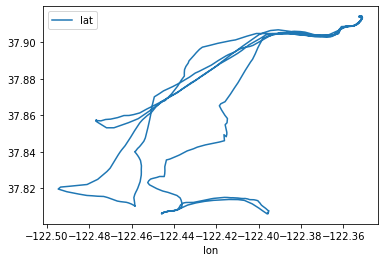

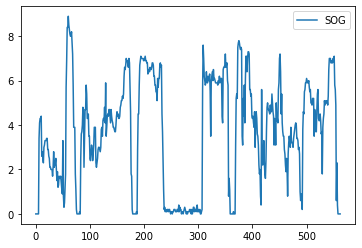

In [79]:
inspect_vessel('367568420', tracks, Plot=True)